# Detecting Swimming Pools using Satellite Imagery and Deep Learning
> * 🔬 Data Science
* 🥠 Deep Learning and Object Detection

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prerequisites" data-toc-modified-id="Prerequisites-1">Prerequisites</a></span></li><li><span><a href="#Introduction-and-objective" data-toc-modified-id="Introduction-and-objective-2">Introduction and objective</a></span></li><li><span><a href="#Part-1---export-training-data-for-deep-learning" data-toc-modified-id="Part-1---export-training-data-for-deep-learning-3">Part 1 - export training data for deep learning</a></span><ul class="toc-item"><li><span><a href="#Import-ArcGIS-API-for-Python-and-get-connected-to-your-GIS" data-toc-modified-id="Import-ArcGIS-API-for-Python-and-get-connected-to-your-GIS-3.1">Import ArcGIS API for Python and get connected to your GIS</a></span></li><li><span><a href="#Prepare-data-that-will-be-used-for-training-data-export" data-toc-modified-id="Prepare-data-that-will-be-used-for-training-data-export-3.2">Prepare data that will be used for training data export</a></span></li><li><span><a href="#Specify-a-folder-name-in-raster-store-that-will-be-used-to-store-our-training-data" data-toc-modified-id="Specify-a-folder-name-in-raster-store-that-will-be-used-to-store-our-training-data-3.3">Specify a folder name in raster store that will be used to store our training data</a></span></li><li><span><a href="#Export-training-data-using-arcgis.learn" data-toc-modified-id="Export-training-data-using-arcgis.learn-3.4">Export training data using <code>arcgis.learn</code></a></span></li></ul></li><li><span><a href="#Part-2---model-training" data-toc-modified-id="Part-2---model-training-4">Part 2 - model training</a></span><ul class="toc-item"><li><span><a href="#Visualize-training-data" data-toc-modified-id="Visualize-training-data-4.1">Visualize training data</a></span></li><li><span><a href="#Load-model-architecture" data-toc-modified-id="Load-model-architecture-4.2">Load model architecture</a></span></li><li><span><a href="#Train-a-model-through-learning-rate-tuning-and-transfer-learning" data-toc-modified-id="Train-a-model-through-learning-rate-tuning-and-transfer-learning-4.3">Train a model through learning rate tuning and transfer learning</a></span></li><li><span><a href="#Detect-and-visualize-swimming-pools-in-validation-set" data-toc-modified-id="Detect-and-visualize-swimming-pools-in-validation-set-4.4">Detect and visualize swimming pools in validation set</a></span></li></ul></li><li><span><a href="#Part-3---deployment-and-inference" data-toc-modified-id="Part-3---deployment-and-inference-5">Part 3 - deployment and inference</a></span><ul class="toc-item"><li><span><a href="#Locate-model-package" data-toc-modified-id="Locate-model-package-5.1">Locate model package</a></span></li><li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-5.2">Model inference</a></span></li></ul></li><li><span><a href="#Visualize-detected-pools-on-map" data-toc-modified-id="Visualize-detected-pools-on-map-6">Visualize detected pools on map</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-8">References</a></span></li></ul></div>

## Prerequisites

- Please refer to the prerequisites section in our [guide](https://developers.arcgis.com/python/guide/geospatial-deep-learning/) for more information. This sample demonstrates how to do export training data and model inference using [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server). Alternatively, they can be done using [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well.
- If you have already exported training samples using ArcGIS Pro, you can jump straight to the training section. The saved model can also be imported into ArcGIS Pro directly.

## Introduction and objective

Deep Learning has achieved great success with state of the art results, but taking it to the field and solving real-world problems is still a challenge. Integration of the latest research in AI with ArcGIS opens up a world of opportunities. This notebook demonstrates an end-to-end deep learning workflow in using ArcGIS API for Python. The workflow consists of three major steps: (1) extracting training data, (2) train a deep learning object detection model, (3) deploy the model for inference and create maps. To better illustrate this process, we choose detecting swmming pools in Redlands, CA using remote sensing imagery.

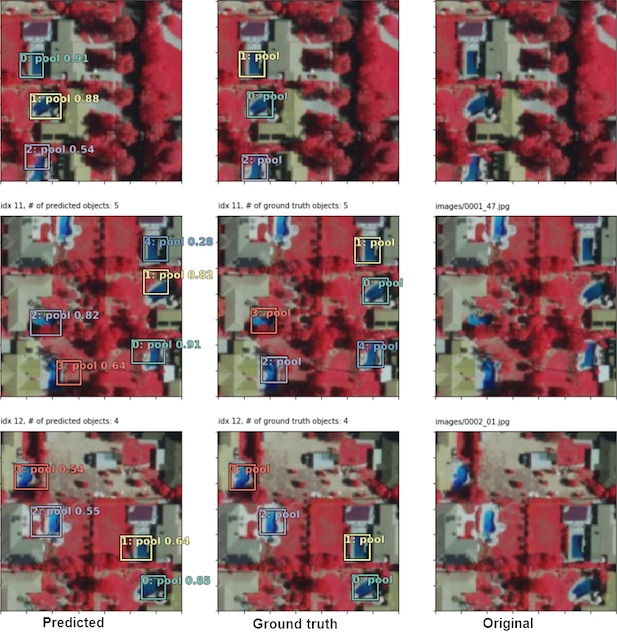

## Part 1 - export training data for deep learning

### Import ArcGIS API for Python and get connected to your GIS

In [1]:
import arcgis
import sys
from arcgis import GIS, learn
from arcgis.raster import analytics
from arcgis.raster.functions import extract_band, apply, clip
from arcgis.raster.analytics import list_datastore_content
from arcgis.learn import SingleShotDetector, prepare_data, Model, list_models, detect_objects 
arcgis.env.verbose = True
from arcgis.geocoding import geocode

In [2]:
gis = GIS(profile='your_enterprise_profile')

### Prepare data that will be used for training data export

To export training data, we need a _labeled feature class_ that contains the bounding box for each object, and a _raster layer_ that contains all the pixels and band information. In this swimming pool detection case, we have created feature class by hand labelling the bounding box of each swimming pool in Redlands using ArcGIS Pro and USA NAIP Imagery: Color Infrared as raster data.

<Item title:"SwimmingPoolLabels" type:Feature Layer Collection owner:arcgis_python>
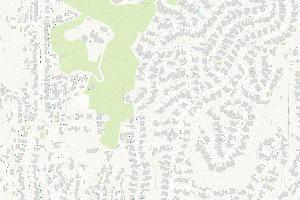

In [3]:
pool_bb = gis.content.search("SwimmingPoolLabels", item_type='Feature Layer Collection')[0]
pool_bb

In [4]:
pool_bb_layer = pool_bb.layers[0]
pool_bb_layer.url

'https://pythonapi.playground.esri.com/server/rest/services/Hosted/SwimmingPoolLabels/FeatureServer/0'

In [5]:
m = gis.map("Prospect Park, Redlands, CA")
m

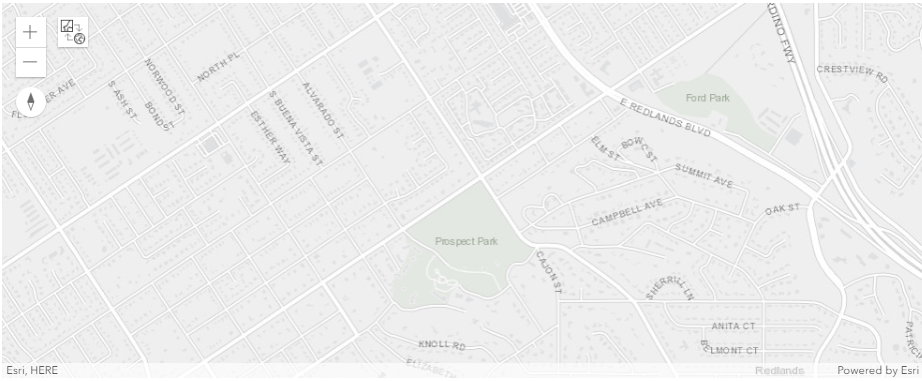

In [6]:
m.basemap = 'gray'

Now let's retrieve the NAIP image layer.

In [7]:
naip_item = gis.content.search("naip_ml", item_type="Imagery Layer", outside_org=True)[0]
naip_item

<Item title:"naip_ml" type:Imagery Layer owner:arcgis_python>

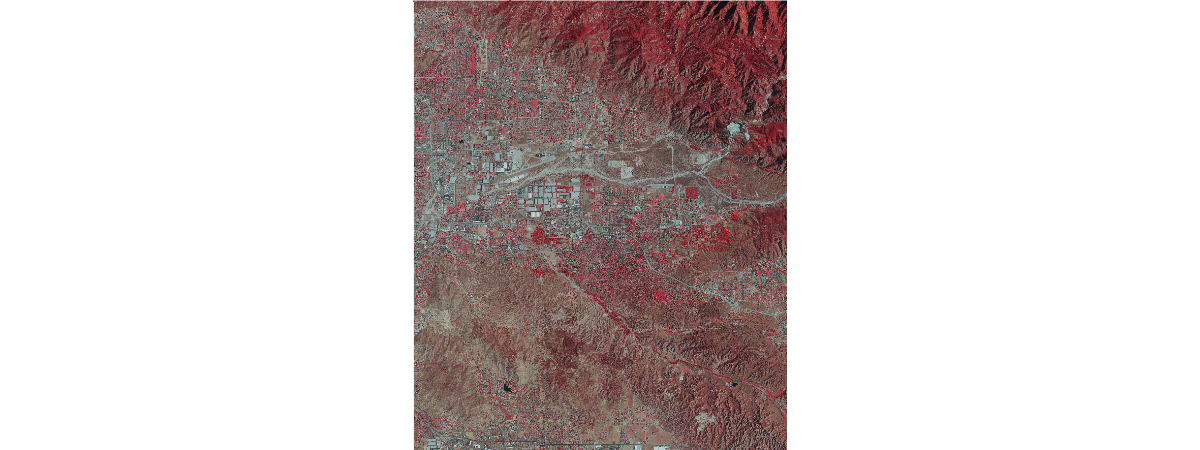

In [8]:
naiplayer = naip_item.layers[0]
naiplayer

In [9]:
m.add_layer(naiplayer)

###  Specify a folder name in raster store that will be used to store our training data

Make sure a raster store is ready on your raster analytics image server. This is where where the output subimages, also called chips, labels and metadata files are going to be stored.

In [10]:
ds = analytics.get_datastores(gis=gis)
ds

In [11]:
ds.search()

[<Datastore title:"/nosqlDatabases/AGSDataStore_bigdata_bds_4c9tuc3o" type:"nosql">,
 <Datastore title:"/nosqlDatabases/AGSDataStore_nosqldb_tcs_l6mh5mhm" type:"nosql">,
 <Datastore title:"/enterpriseDatabases/AGSDataStore_ds_b6108wk9" type:"egdb">,
 <Datastore title:"/rasterStores/LocalRasterStore" type:"rasterStore">]

In [12]:
rasterstore = ds.get("/rasterStores/LocalRasterStore")
rasterstore

<Datastore title:"/rasterStores/LocalRasterStore" type:"rasterStore">

In [13]:
samplefolder = "pool_chips"
samplefolder

### Export training data using `arcgis.learn`

With the feature class and raster layer, we are now ready to export training data using the export_training_data() method in arcgis.learn module. In addtion to feature class, raster layer, and output folder, we also need to speficy a few other parameters such as tile_size (size of the image chips), strid_size (distance to move in the X when creating the next image chip), chip_format (TIFF, PNG, or JPEG), metadata format (how we are going to store those bounding boxes). More detail can be found [here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm). 

Depending on the size of your data, tile and stride size, and computing resources, this opertation can take 15mins~2hrs in our experiment. Also, do not re-run it if you already run it once unless you would like to update the setting.

<Item title:"SwimmingPoolLabels" type:Feature Layer Collection owner:arcgis_python>
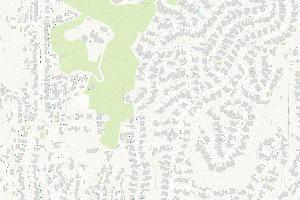

In [14]:
pool_bb

In [15]:
pool_bb_layer

<FeatureLayer url:"https://datascienceadv.esri.com/server/rest/services/Hosted/SwimmingPoolLabels/FeatureServer/0">

In [16]:
export = learn.export_training_data(input_raster=naiplayer,
                                           output_location=samplefolder,
                                           input_class_data=pool_bb_layer, 
                                           chip_format="PNG", 
                                           tile_size={"x":448,"y":448}, 
                                           stride_size={"x":224,"y":224}, 
                                           metadata_format="PASCAL_VOC_rectangles",                                        
                                           classvalue_field = "Id",
                                           buffer_radius = 6,
                                           context={"startIndex": 0, "exportAllTiles": False},
                                           gis = gis)

export

Now let's get into the raster store and look at what has been generated and exported.

In [17]:
samples = list_datastore_content(rasterstore.datapath + '/' + samplefolder + "/images", filter = "*png")
# print out the first five chips/subimages
samples[0:5]

Submitted.
Executing...
Start Time: Thursday, February 21, 2019 9:44:27 PM
Running script ListDatastoreContent...


['/rasterStores/LocalRasterStore/pool_chips_yongyao/images/000000000.png',
 '/rasterStores/LocalRasterStore/pool_chips_yongyao/images/000000001.png',
 '/rasterStores/LocalRasterStore/pool_chips_yongyao/images/000000002.png',
 '/rasterStores/LocalRasterStore/pool_chips_yongyao/images/000000003.png',
 '/rasterStores/LocalRasterStore/pool_chips_yongyao/images/000000004.png']

In [18]:
labels = list_datastore_content(rasterstore.datapath + '/' + samplefolder + "/labels", filter = "*xml")
# print out the labels/bounding boxes for the first five chips
labels[0:5]

Start Time: Thursday, February 21, 2019 9:44:29 PM
Running script ListDatastoreContent...
Completed script ListDatastoreContent...
Succeeded at Thursday, February 21, 2019 9:44:29 PM (Elapsed Time: 0.05 seconds)


['/rasterStores/LocalRasterStore/pool_chips_yongyao/labels/000000000.xml',
 '/rasterStores/LocalRasterStore/pool_chips_yongyao/labels/000000001.xml',
 '/rasterStores/LocalRasterStore/pool_chips_yongyao/labels/000000002.xml',
 '/rasterStores/LocalRasterStore/pool_chips_yongyao/labels/000000003.xml',
 '/rasterStores/LocalRasterStore/pool_chips_yongyao/labels/000000004.xml']

We can also create a image layer using one of this images and look at what it looks like. Note that a chip may or may not have a bounding box in it and one chip might have multiple boxes as well.

## Part 2 - model training

If you've already done part 1, you should already have both the training chips and swimming pool labels. Please change the path to your own export training data folder that contains "images" and "labels" folder.

In [2]:
import os
from pathlib import Path

gis = GIS('home')

<Item title:"detecting_swimming_pools_using_satellite_image_and_deep_learning" type:Image Collection owner:api_data_owner>
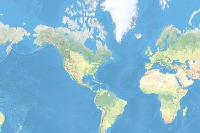

In [3]:
training_data = gis.content.get('73a29df69b344ce8b94fdb4c9df7103d')
training_data

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
data_path = Path(os.path.join(filepath.split('.')[0]))

In [20]:
data = prepare_data(data_path, {0:'Pool'}, batch_size=32)
data.classes

['background', 'Pool']

### Visualize training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them.

CPU times: user 3.43 s, sys: 1.14 s, total: 4.57 s
Wall time: 26.5 s


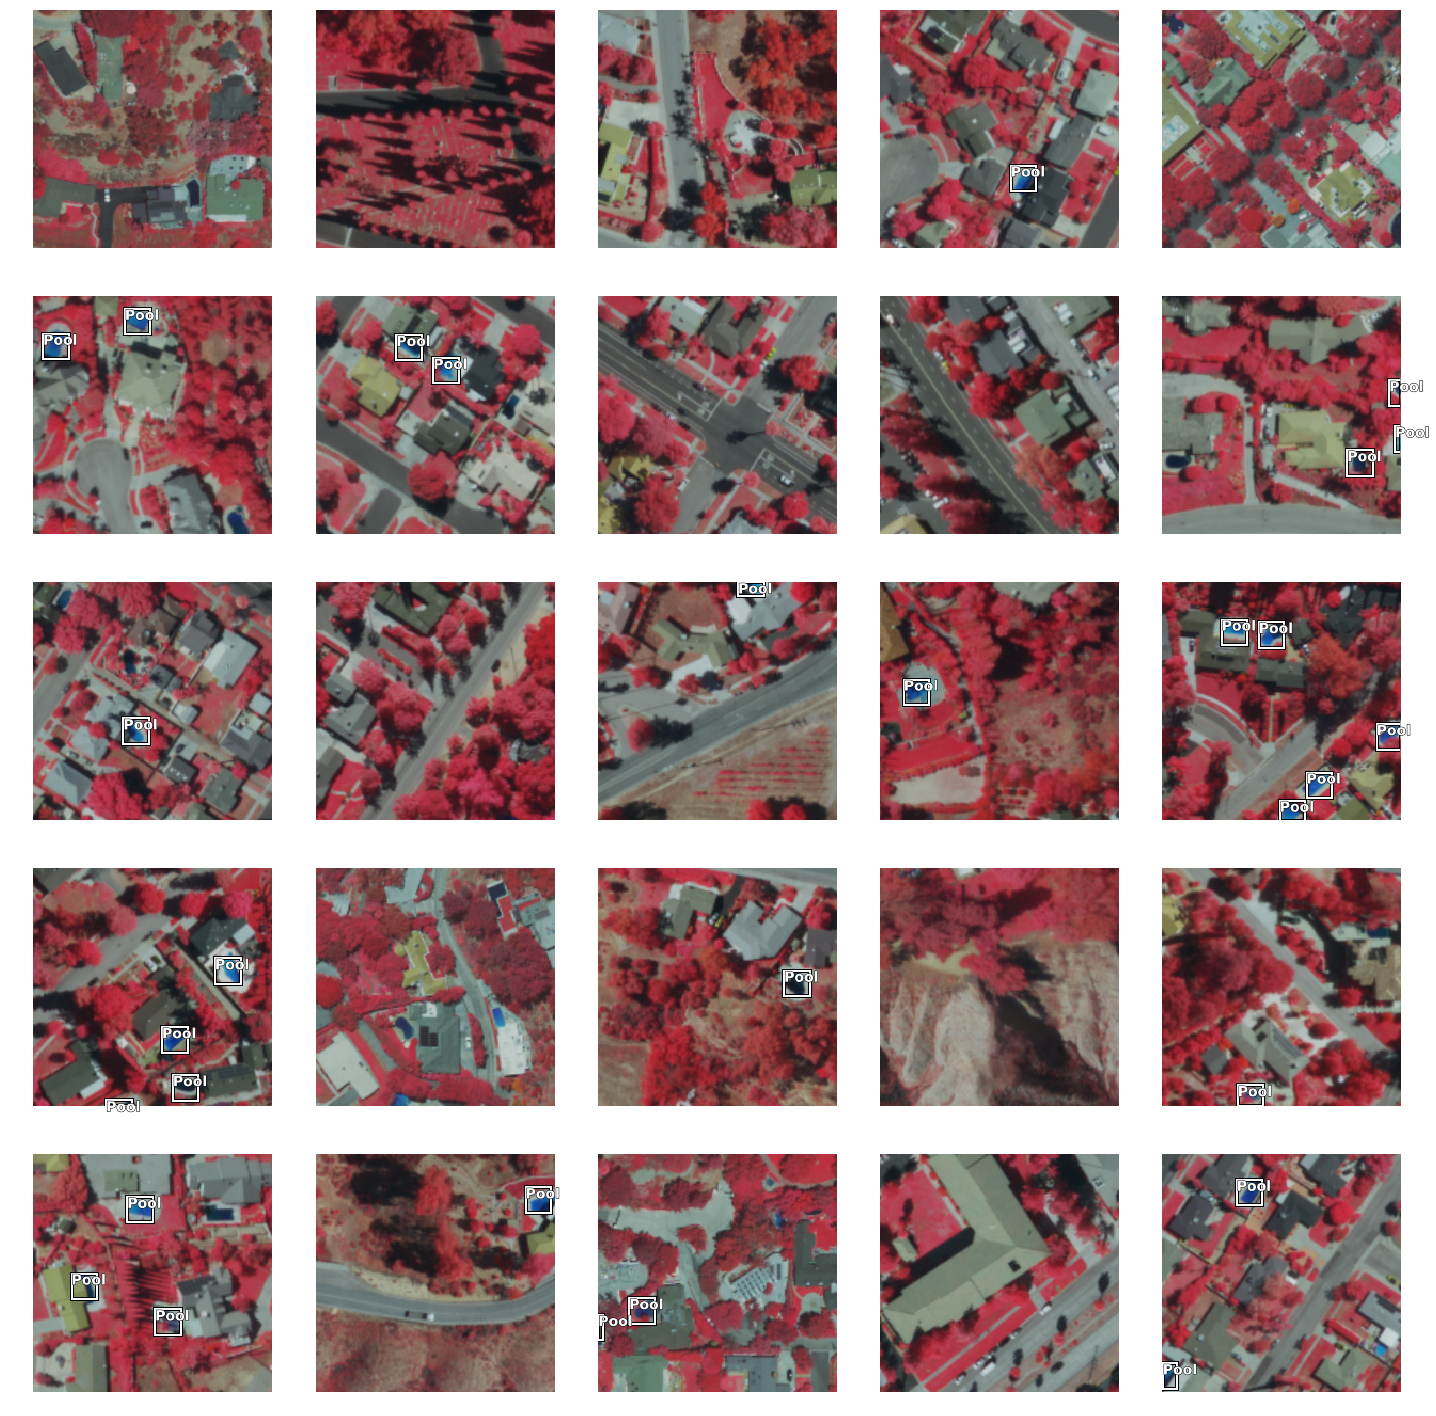

In [21]:
%%time
data.show_batch()

### Load model architecture
Here we use Single Shot MultiBox Detector (SSD) [1], a well-recognized object detection algorithm, for swimming pool detection. A SSD model architecture using Resnet-34 as the base model has already been predefined in ArcGIS API for Python, which makes it easy to use.

<img src="https://cdn-images-1.medium.com/max/1000/1*GmJiirxTSuSVrh-r7gtJdA.png">
<center>Architecture of a convolutional neural network with a SSD detector [1]</center>

In [22]:
ssd = SingleShotDetector(data, grids=[5], zooms=[1.0], ratios=[[1.0, 1.0]])

### Train a model through learning rate tuning and transfer learning
[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. Here we explore a range of learning rate to guide us to choose the best one.

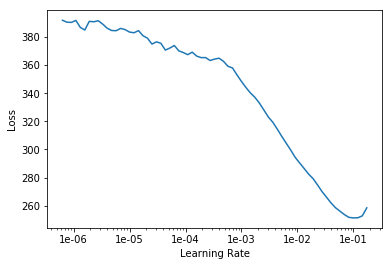

In [23]:
ssd.lr_find()

Based on the learning rate plot above, we can see that the loss starts going down from 1e-4. Therefore, we set learning rate to be a range from 1e-4 to 3e-3, which means we will apply smaller rates to the first few layers and larger rates for the last few layers, and intermediate rates for middle layers, which is the idea of transfer learning. Let's start with 10 epochs for the sake of time.

In [24]:
ssd.fit(10, lr=slice(1e-3, 3e-2))

### Detect and visualize swimming pools in validation set
Now we have the model, let's look at how the model performs. Here we plot out 5 rows of images and a threshold of 0.3. Threshold is a measure of probablity that a swimming pool exists. Higher value meas more confidence.

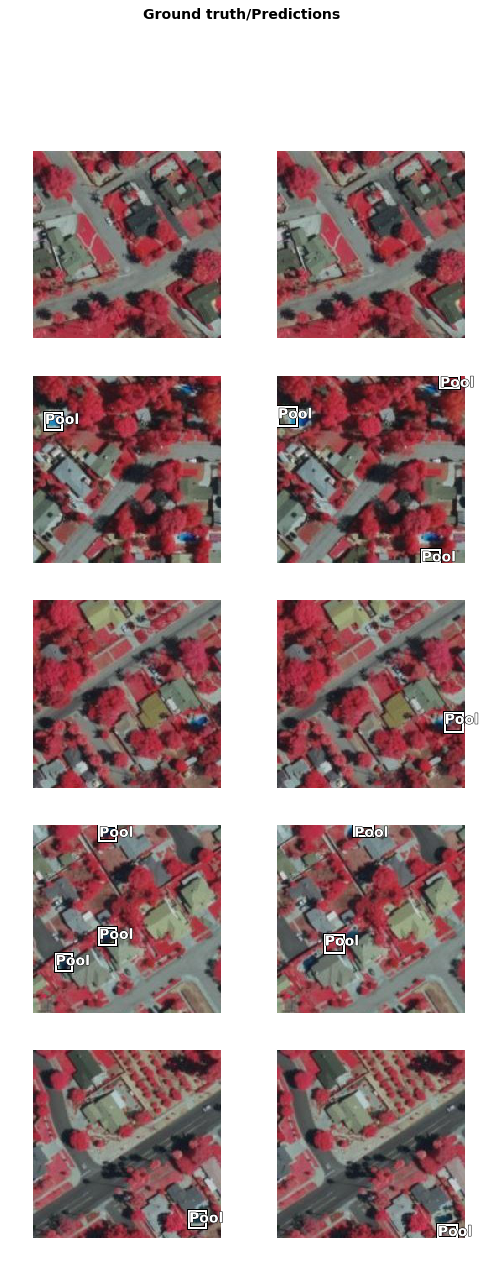

In [25]:
ssd.show_results(thresh=0.3)

As we can see, with only 10 epochs, we are already seeing reasonable results. Further improvment can be acheived through more sophisticated hyperparameter tuning. Let's save the model for further training or inference later. The model should be saved into a models folder in your folder. By default, it will be saved into your `data_path` that you specified in the very beginning of this notebook.

In [26]:
ssd.save('5x5-10-deploy')

## Part 3 - deployment and inference

### Locate model package
If you have finished Part 2 of this notebook series, you should have a models folder saved already. The model package is the "5x5-50.zip" zip file in the folder.
The the model package file includes several files:
1. A model definition file with the extension .emd which includes information like model framework (e.g. tensorflow, pytorch). ArcGIS will need it to interpret your model.
2. A model file in binary format that we have developed in Part 2.
3. If your framework is not supported yet, a custom python raster function has to be added as well.
Third, get the deep learning model package file path. _Please change it to your own path_.

In [27]:
model_package = "Path_To_Your_Model_Package"

In [28]:
detect_objects_model_package = gis.content.add(item_properties={"type":"Deep Learning Package",
                                                                "typeKeywords":"Deep Learning, Raster",
                                                                "title":"Pool_Detection7",
                                                                "tags":"deeplearning", 'overwrite':'True'}, 
                                               data=model_package)
detect_objects_model_package

Now we are ready to install the mode. Installation of the deep learning model item will unpack the model definition file, model file and the inference function script, and copy them to "trusted" location under the Raster Analytic Image Server site's system directory. 

In [29]:
detect_objects_model = Model(detect_objects_model_package)

In [30]:
detect_objects_model.install()

'[resources]models\\raster\\80a80b4a63714be5a13c57b16a37ade4\\5x5-10-deploy.emd'

In [31]:
detect_objects_model.query_info()

{'Framework': 'arcgis.learn.models._inferencing',
 'ModelType': 'ObjectDetection',
 'ParameterInfo': [{'name': 'raster',
   'dataType': 'raster',
   'required': '1',
   'displayName': 'Raster',
   'description': 'Input Raster'},
  {'name': 'model',
   'dataType': 'string',
   'required': '1',
   'displayName': 'Input Model Definition (EMD) File',
   'description': 'Input model definition (EMD) JSON file'},
  {'name': 'device',
   'dataType': 'numeric',
   'required': '0',
   'displayName': 'Device ID',
   'description': 'Device ID'},
  {'name': 'padding',
   'dataType': 'numeric',
   'value': '0',
   'required': '0',
   'displayName': 'Padding',
   'description': 'Padding'},
  {'name': 'threshold',
   'dataType': 'numeric',
   'value': '0.5',
   'required': '0',
   'displayName': 'Confidence Score Threshold [0.0, 1.0]',
   'description': 'Confidence score threshold value [0.0, 1.0]'},
  {'name': 'nms_overlap',
   'dataType': 'numeric',
   'value': '0.1',
   'required': '0',
   'display

### Model inference
To test our model, let's get a raster image with some swimming pools.

In [32]:
out_objects = detect_objects(input_raster=naiplayer.url,
                             model=detect_objects_model,
                             output_name="pooldetection_full_redlands",
                             context={'cellSize': 0.42, 'processorType': 'GPU'},
                             gis=gis)

out_objects

<Item title:"pooldetection_full_redlands" type:Feature Layer Collection owner:arcgis_python>

## Visualize detected pools on map


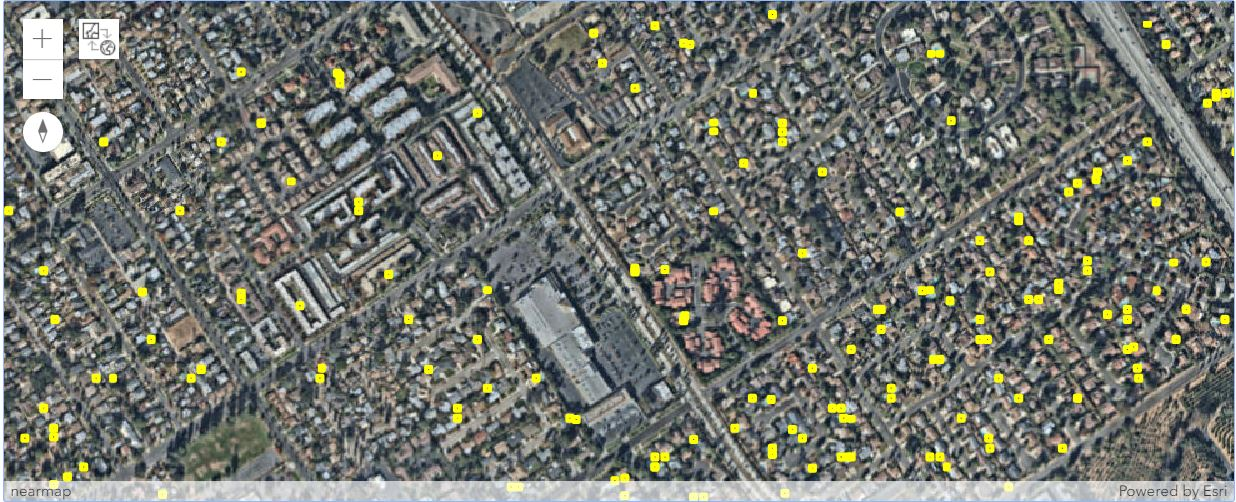

In [33]:
result_map = gis.map('Redlands, CA')
result_map.basemap='satellite'
result_map.add_layer(out_objects)
result_map

## Conclusion
In thise notebook, we have covered a lot of ground. In part 1, we discussed how to export training data for deep learning using ArcGIS python API and what the output looks like. In part 2, we demonstrated how to prepare the input data, train a object detection model, visualize the results, as well as apply the model to an unseen image using the deep learning module in ArcGIS API for Python. Then we covered how to install and publish this model and make it production-ready in part 3.

## References
[1]
Wei Liu, Dragomir Anguelov, Dumitru Erhan, Christian Szegedy, Scott Reed, Cheng-Yang Fu: “SSD: Single Shot MultiBox Detector�?, 2015; <a href='http://arxiv.org/abs/1512.02325'>arXiv:1512.02325</a>.